In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from truecolours_loader import load_and_parse_by_disease_from_pickle
from truecolours_parser import load_for_NANCY_UCEIS_regression
from sklearn.preprocessing import StandardScaler
import random,torch,torchcde
from neural_cdes.regression_cde import CDEModel

## Filter to Patients with More than k Nancy & UCEIS Index Scores

(array([235.,   1.,  82.,   2.,   0., 160.,   1., 290.,   3., 208.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

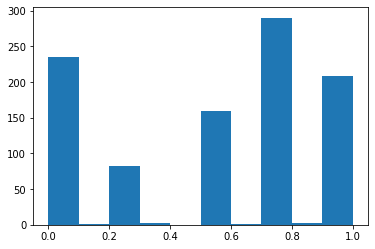

In [28]:
plt.hist(a)

In [34]:
s = np.array([4,8])

In [36]:
y

array([[0.5  , 0.625],
       [0.   , 0.   ],
       [1.   , 0.875],
       ...,
       [1.   , 0.625],
       [1.   , 0.5  ],
       [1.   , 0.625]])

In [35]:
y / s

array([[0.125   , 0.078125],
       [0.      , 0.      ],
       [0.25    , 0.109375],
       ...,
       [0.25    , 0.078125],
       [0.25    , 0.0625  ],
       [0.25    , 0.078125]])

In [19]:
a = a[(~np.isnan(a))&(~np.isnan(b))]
b = b[(~np.isnan(a))&(~np.isnan(b))]

In [3]:
have_NANCY_and_UCEIS = (~UC_df['UCEIS (0 to 8)'].isna()) & (~UC_df['Nancy Index'].isna())
truth_events = UC_df.loc[have_NANCY_and_UCEIS, ['participant_id', 'response_date','UCEIS (0 to 8)','Nancy Index']].drop_duplicates().reset_index(drop=True)

patients_value_counts = truth_events['participant_id'].value_counts()
patients_that_have_more_than_k = np.array(patients_value_counts.index[patients_value_counts>4])

In [4]:
X = []
y = []

for p_id in patients_that_have_more_than_k:
     # Get data for this patient for UC and CD events resp
    x_i = UC_df.loc[(UC_df['participant_id'] == p_id),['time', 'days_since_last_response', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']]
    # The y label we want to predict
    y_i = UC_df.loc[(UC_df['participant_id'] == p_id),['UCEIS (0 to 8)','Nancy Index']]
    
    X.append(x_i)
    y.append(y_i)
    
max_length = np.max([len(xi) for xi in X])
for i in range(len(X)):
    ffill_df_X = X[i].iloc[np.repeat(-1, max_length - len(X[i]))]  # The last row of xi repeated correct # times
    X[i] = pd.concat([X[i], ffill_df_X], ignore_index=True)
    
    ffill_df_y = y[i].iloc[np.repeat(-1, max_length - len(y[i]))]  # The last row of xi repeated correct # times
    y[i] = pd.concat([y[i], ffill_df_y], ignore_index=True)

# Stack into a big matrix
X_stacked = np.stack(X)
y = np.stack(y)

# Transform
X_scaler = StandardScaler() # SKlearn standard scaler
X_scaled = X_scaler.fit_transform(X_stacked.reshape(-1, X_stacked.shape[-1])).reshape(X_stacked.shape)
X_scaled[:,:,0] = X_stacked[:,:,0]/X_stacked[:,:,0].max() # Rescale time coord to be in [0,1]
y_scaled = (y - 2.4) / 1.8 # Hard code mean and std for ease (lol)

## Let's see what we have

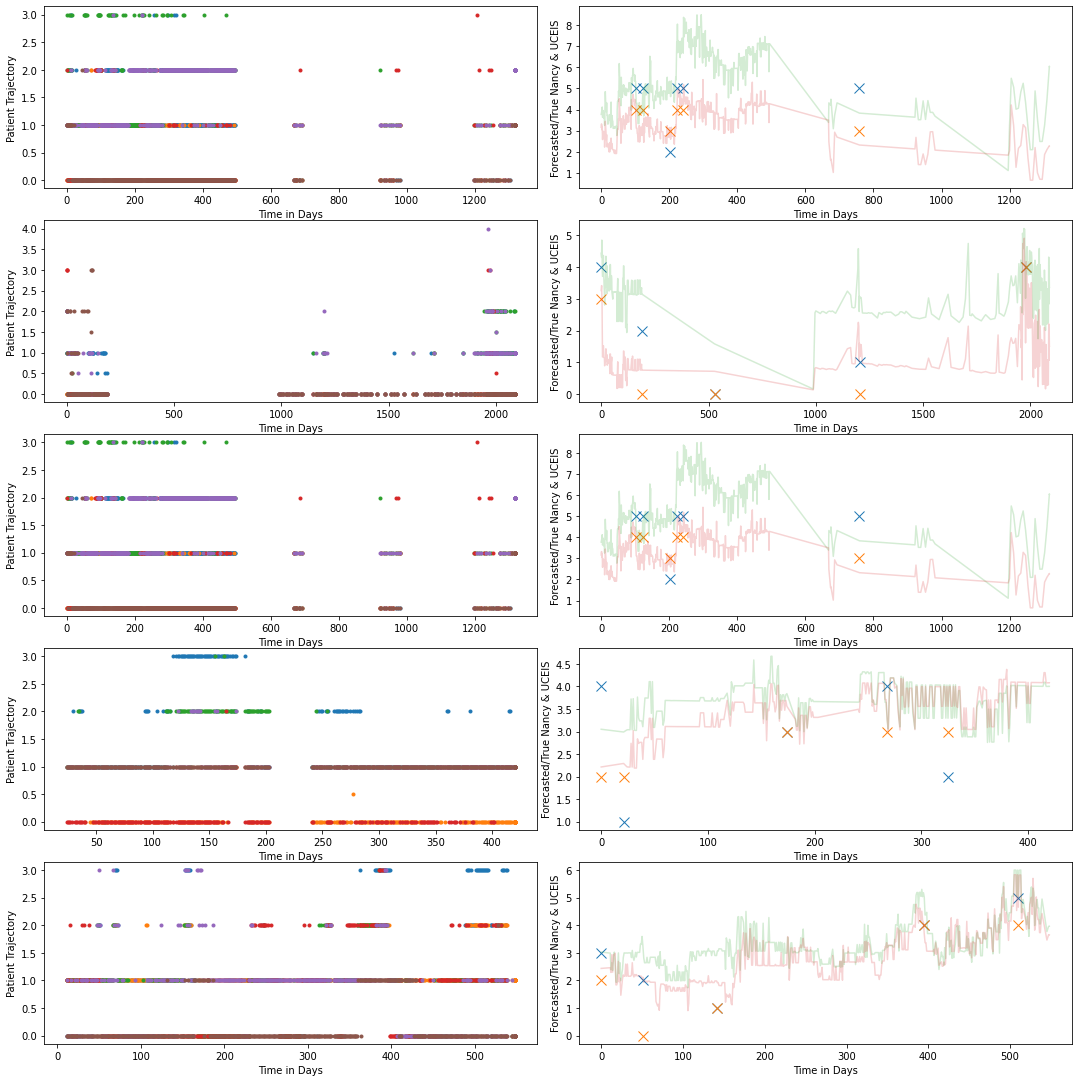

In [29]:
fig, axes = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout()
idxs = random.choices(range(len(y)), k = 5)
    
for i,idx in enumerate(idxs):
    # Plot data
    axes[i,0].plot(X_stacked[idx,:,0],X_stacked[idx,:,2:],ls='none',marker='.')
    axes[i,0].set_xlabel("Time in Days")
    axes[i,0].set_ylabel("Patient Trajectory")

    # Plot predicted labels
    axes[i,1].plot(X_stacked[idx,:,0],y[idx],ls='none',marker='x',markersize=10,alpha=1)
    axes[i,1].plot(X_stacked[idx,:,0],y_hat[idx],alpha=0.2)

    axes[i,1].set_xlabel("Time in Days")
    axes[i,1].set_ylabel("Forecasted/True Nancy & UCEIS")
plt.show()


### Load Model

In [6]:
timestr = "2022_02_28_13:03"
device = torch.device('cpu')
model = CDEModel(**torch.load(f'../experiments/saved_models/{timestr}/args_at_epoch_20.p',map_location=device))
model.load_state_dict(torch.load(f'../experiments/saved_models/{timestr}/model_at_epoch_20.p',map_location=device))
model.eval()
history = pd.read_csv(f'../experiments/saved_models/{timestr}/history.csv')

In [7]:
X_tensor = torch.from_numpy(X_scaled).float()
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_tensor)

In [8]:
coeffs.to(device)
X_tensor.to(device)
model.to(device)

CDEModel(
  (func): F(
    (linear1): Linear(in_features=32, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (linear3): Linear(in_features=128, out_features=256, bias=True)
  )
  (initial): Linear(in_features=8, out_features=32, bias=True)
  (readout): Linear(in_features=32, out_features=2, bias=True)
)

In [9]:
y_hat_tensor = model.forward_return_all_times(coeffs)

In [10]:
y_hat = y_hat_tensor.detach().numpy()
y_hat = (y_hat * 1.8) + 2.4

In [28]:
model.readout.bias

Parameter containing:
tensor([ 0.0851, -0.0314], requires_grad=True)